*The code snippet assumes Anaconda 5.2.0 version of Python virtual environment*

<div class="alert alert-info">
    <h4>Acknowledgement</h4>
    <p>The materials on this post are based the two research paper, <a href="https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf">Distributed Representations of Words and Phrases and their Compositionality</a> (Mikolov et al., 2013) and <a href="https://arxiv.org/pdf/1411.2738.pdf">word2vec Parameter Learning Explained</a> (Rong, 2014).</p>
</div>

Word Embedding - represent words in a vector space



## Paradigm Shift in Word Embedding: Frequency-Based to Prediction-Based

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"

++ Pandas Table

Limitation of Count-Based Method:
1. someting
2. something
3. something

To combat these issues, a novel prediction-based word embedding technique called Word2Vec was introduced by Thomas Mikolov in 2013. 

## Prediction-based word-embedding: Word2Vec Skip-Gram

picture of mikolov skip-gram diagram + my diagram of window_size = 2

skip-gram predicts context words given a center word.


<div class="alert alert-info">
    <h4>Notes: CBOW and Skip-Gram</h4>
    <p>There are two models for Word2Vec: <i>Continous Bag Of Words (CBOW)</i> and <i>Skip-Gram</i>. While Skip-Gram model predicts context words given a center word, CBOW model predicts a center word given context words. According to Mikolov:</p>
    <p><i>Skip-gram</i>: works well with small amount of the training data, represents well even rare words or phrases</p>
    <p><i>CBOW</i>: several times faster to train than the skip-gram, slightly better accuracy for the frequent words</p>
    <p>Skip-Gram model is a better choice most of the time due to its ability to predict infrequent words, but this comes at the price of increased computational cost. If training time is a big concern, and you have large enough data to overcome the issue of predicting infrequent words, CBOW model may be a more viable choice. The details of CBOW model won't be covered in this post.</p>
</div>

A natural question is, why do we predict context words? First, we need to understand the structure of Skip-Gram.

## Defining Loss Function

$$ J(\theta) = -\frac{1}{T} \sum^T_{t=1} \sum_{-m\leq j \leq m} \log p(w_{t+j} \mid w_t ; \theta) $$


### Neural network structure of Skip-Gram

How does predicting context words help with constructing Word2Vec model and representing words in a vector space? One needs to look into the structure of Skip-Gram model to gain insights about their correlation. 

For illustration purpose, let's will assume that the entire corpus is composed of the quote from the Game of Thrones, <i>"The man who passes the sentence should swing the sword"</i>, by Ned Stark. There are 10 words ($T = 10$), and 8 unique words ($V = 8$). 

Note that in real life, the corpus is much bigger than just one sentence. 

<blockquote class="quote">
  The man who passes the sentence should swing the sword.
  <span>- Ned Stark</span>
</blockquote>

We will use <code>window=1</code>, and assume that <i>'passes'</i> is the current center word, making <i>'who'</i> and <i>'the'</i> context words. <code>window</code> is a hyper-parameter that can be empirically tuned. It typically has a range of 2-10.

<div class="row give-margin-inline-big-plot">
    <div class="col"><img src="jupyter_images/quote_ned_stark.png"></div>
    <div class="col-12"><p class="image-description">Figure 1: Training Window</p></div>
</div>

For illustration purpose, a three-dimensional neural net will be constructed. In *gensim*, this can be implemented by setting <code>size=3</code>. This makes $N = 3$. Just like <code>window</code>, <code>size</code> is a hyper-parameter that can be empirically tuned. In real life, a typical Word2Vec model has 200-600 neurons. 

<pre>
    <code class="language-python">
        from gensim.models import Word2Vec

        model = Word2Vec(corpus, size=3, window=1)
    </code>
</pre>

This means that the input weight matrix ($W_{input}$) will have a size of $8 \times 3$, and output weight matrix ($W_{output}$) will have a size of $3 \times 8$. Recall that the corpus, <i>"The man who passes the sentence should swing the sword"</i>, has 8 unique vocabularies ($V = 8$). 

<div class="row">
    <div class="col"><img src="jupyter_images/word2vec_skip-gram.png" style="margin: 0;"></div>
    <div class="col-12"><p class="image-description">Figure 2: Skip-Gram model structure</p></div>
</div>
<div><hr></div>


**Input Layer** ($x$)

The input layer is one-hot encoded vector of size  $1 \times V$. Every element in the vector is 0 except one element that corresponds to the center word. Input vector is multiplied with the input weight matrix ($W_{input}$) of size $V \times N$, and yields an one-dimenasional hidden (projection) layer ($h$) of size $1 \times N$. Because the input layer is one-hot encoded, it makes the input weight matrix ($W_{input}$) to behave like a "look-up table" for the center word.

<div class="row give-margin-inline-big-plot">
    <div class="col"><img src="jupyter_images/one-hot-vector.png"></div>
    <div class="col-12"><p class="image-description">Figure 2: One-hot encoded input vector and parameter update</p></div>
</div>

Assuming epoch number of 1 (<code>iter=1</code> in *gensim* Word2Vec implementation), the input vector is injected into the network $T$ times for every word in the corpus and makes $T$ updates to the weight matrix ($\theta$). In Skip-Gram model, weight matrix ($\theta$) can also be expressed as $[W_{input} \quad W_{output}]^T$ — concatenation of input weight matrix ($W_{input}$) and output weight matrix ($W_{output}$). 

<div class="alert alert-info">
    <h4>Notes: Stochastic Gradient Descent</h4>
    <p>The goal of any machine learning model is to find the optimal values of a weight matrix ($\theta$) to minimize prediction error. A general update equation for weight matrix looks like the following:</p>
    <p><center style="margin-top: 20px">$\theta_{new}=\theta_{old}-\eta\cdot\nabla_{\theta}J(\theta)$</center></p>
    <p>$\eta$ is learning rate, $\nabla_{\theta}$ is gradient for the weight matrix, and $J(\theta)$ is the cost function that has different forms for each model. The cost function for the Skip-Gram model proposed in the <a href="https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf">Word2Vec original paper</a> has the following equation:</p>
    <p><center style="margin-top: 20px">$$J(\theta) = -\frac{1}{T} \sum^T_{t=1} \sum_{-m\leq j \leq m} \log p(w_{t+j} \mid w_t ; \theta)$$</center></p>
    <p>Here, what gives us headache is the expression, $\frac{1}{T} \sum^T_{t=1}$, because $T$ can be larger than billions or more in many NLP applications. It is basically telling us that billions of iterations need to be computed to make just one update to the weight matrix ($\theta$). In order to mitigate this computational burden, the author of the paper states that Stochastic Gradient Descent (SGD) was used for parameter optimization. SGD removes the expression, $\frac{1}{T} \sum^T_{t=1}$, from the cost function and performs parameter update for each training example, $w^{(t)}$:</p>
    <p><center style="margin-top: 20px">$$J_{t}(\theta;w^{(t)}) = -\sum_{-m\leq j \leq m} \log p(w_{t+j} \mid w_t ; \theta)$$</center></p>
    <p>Then, the new parameter update equation for SGD becomes:</p>
    <p><center style="margin-top: 20px">$\theta_{new}=\theta_{old}-\eta\cdot\nabla_{\theta}J_{t}(\theta;w^{(t)})$</center></p>
    <p></p>
</div>

**Input and Output Weight Matrix** ($W_{input}$, $W_{output}$)

FAQ


Error 3D plot at the introduction of minimizing J(theta) cost function.

If the center word is the same as context word, it is skipped. https://github.com/RaRe-Technologies/gensim/blob/f267abf94e84484047fb7569ebacba5626bc8391/gensim/models/word2vec.py#L129

In [ ]:
len(context) * np.log(np.sum(np.exp(u))) - np.sum([u[label == 1] for label in context])

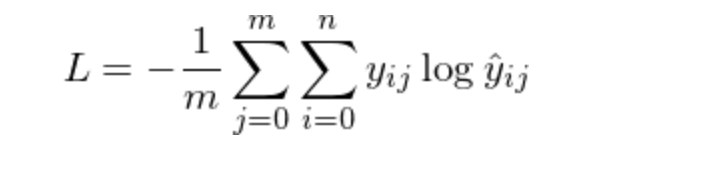

In [1]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

In [2]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encodeing of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: alaph in the weight update formula
    epochs: how many epochs to train the model
    batch_size: size of mini batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print costs during the training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:=            learning_rate *= 0.98
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters